<a href="https://colab.research.google.com/github/ykitaguchi77/Laboratory_course/blob/master/11.%20GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GradCAM 診断根拠の可視化**

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline


plt.ion()   # interactive mode
np.random.seed(1234)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#dataset.zipを解凍

!date -R
!unzip -qq drive/My\ Drive/AI_laboratory_course/dataset.zip
!date -R
!ls

shutil.move("/content/train/appl", "/content/appl")
shutil.move("/content/train/stra", "/content/stra")
shutil.rmtree("/content/train")
shutil.rmtree("/content/val")

Mounted at /content/drive
Mon, 22 Jan 2024 07:36:27 +0000
Mon, 22 Jan 2024 07:36:37 +0000
drive  sample_data  train  val


In [3]:
#trainとvalにランダムに分けるスクリプト

import glob
import os
import random
import shutil
from sklearn.model_selection import train_test_split

class_names = ["appl", "stra"] ###←ここを変更してください
parent_dir = f'/content' ###←ここを変更してください


for class_name in class_names:

    # location of the dataset
    orig_dir = f'{parent_dir}/{class_name}'

    # get the list of all files in the folder
    all_files = glob.glob(f"{orig_dir}/*")

    print(f"len_all_files: {len(all_files)}")

    # split the list into train and validation sets
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=0)

    # create the train and validation folders if they don't exist
    train_folder = f'/content/train/{class_name}'
    val_folder = f'/content/val/{class_name}'
    if os.path.exists(train_folder):
        shutil.rmtree(train_folder)
    os.makedirs(train_folder)
    if os.path.exists(val_folder):
        shutil.rmtree(val_folder)
    os.makedirs(val_folder)

    # copy the files from the dataset folder to the train and validation folders
    for file in train_files:
        new_location = f"{train_folder}/{os.path.basename(file)}"
        shutil.copy(file, new_location)

    for file in val_files:
        new_location = os.path.join(val_folder, os.path.basename(file))
        shutil.copy(file, new_location)

len_all_files: 252
len_all_files: 252


In [4]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path= data_dir + '/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path= data_dir + '/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))

['appl', 'stra']
appl_train:201
stra_train:201
appl_val:51
stra_val:51
training data set_total：402
validating data set_total：102


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#**GradCAM**

In [5]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/content'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path= data_dir + '/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path= data_dir + '/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))

['appl', 'stra']
appl_train:201
stra_train:201
appl_val:51
stra_val:51
training data set_total：402
validating data set_total：102


In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device) #GPU使用


PATH = '/content/drive/My Drive/AI_laboratory_course/classification.pth'
model_ft.load_state_dict(torch.load(PATH))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


<All keys matched successfully>

In [39]:
#########################
## ここからGradCAM
#########################


import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm

class Flatten(nn.Module):
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

def GradCAM(img, c, features_fn, classifier_fn): #cはclass
    feats = features_fn(img.cuda()) #imgをforwardする
    #print(f"feats: {feats}")
    _, N, H, W = feats.size() #[1,2048,7,7]
    out = classifier_fn(feats)
    #print(f"out: {out}") #out: tensor([[ 1.1058, -1.4082]], device='cuda:0', grad_fn=<AddmmBackward0>)
    c_score = out[0, c]   #該当するclassのscore (model_ftを通した場合)

    grads = torch.autograd.grad(c_score, feats)
    #print(f"grads: {grads[0].shape}") #torch.Size([1, 512, 7, 7])
    #print(f"grads: {grads[0][0].shape}") #torch.Size([512, 7, 7])

    w = grads[0][0].mean(-1).mean(-1)           #ここでGlobalAveragePoolingをしている
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0) #ReLUと同じ
    return sal

read_tensor = transforms.Compose([
    lambda x: Image.open(x),
    lambda x: x.convert('RGB'),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    lambda x: torch.unsqueeze(x, 0) #次元を1に引き延ばす
])

#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      #print('Image: '+ image_name)
      label = os.path.basename(os.path.dirname(image_path))
      #print('Label: '+ label)
      return(image_name, label)

In [ ]:
# Split model in two parts
features_fn = nn.Sequential(*list(model_ft.children())[:-2]) #最後の2層（AdaptiveAvgPool2dとLinear)を取り除いたもの
classifier_fn = nn.Sequential(*(list(model_ft.children())[-2:-1] + [Flatten()] + list(model_ft.children())[-1:])) #最終層の前にFlatten()を挿入
#最後の2層

In [ ]:
model_ft

In [ ]:
features_fn

In [ ]:
classifier_fn

<ipython-input-40-4c8d0997cba1>:35: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  sal = sal.resize(img.size, resample=Image.LINEAR)


grads: torch.Size([1, 512, 7, 7])
grads: torch.Size([512, 7, 7])

label: appl
pred:  appl  92.5%


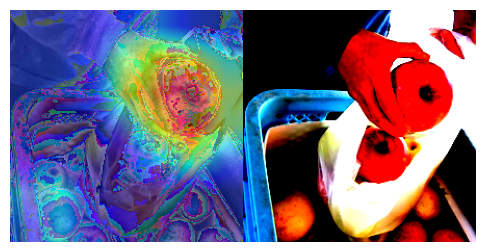

In [40]:
# Split model in two parts
features_fn = nn.Sequential(*list(model_ft.children())[:-2]) #最後の2層（AdaptiveAvgPool2dとLinear)を取り除いたもの
classifier_fn = nn.Sequential(*(list(model_ft.children())[-2:-1] + [Flatten()] + list(model_ft.children())[-1:])) #最終層の前にFlatten()を挿入
 #最後の2層

#評価モードにする
model_ft = model_ft.eval()
model_ft = model_ft.to(device)


classes = ["appl", "stra"]

#画像のパスを指定
for j in range(1):
#for j in range(len(image_datasets["val"])):

    #元画像

    image = image_datasets["val"][j][0]
    image = image.permute(1, 2, 0)

    img_tensor = image_datasets["val"][j][0].unsqueeze(0)
    #Softmaxにかけたときの確率上位1つのpp(確率)とcc(class番号)を取得(0→apple,1→stra)
    pp, cc = torch.topk(nn.Softmax(dim=1)(model_ft(img_tensor.to(device))), 1)
    #print(pp, cc) #tensor([[0.9251]], device='cuda:0', grad_fn=<TopkBackward0>) tensor([[0]], device='cuda:0')

    #pとcを対にして入力
    for i, (p, c) in enumerate(zip(pp[0], cc[0])):  #これでtensorを外す
        #print(p, c) #tensor(0.9251, device='cuda:0', grad_fn=<UnbindBackward0>) tensor(0, device='cuda:0')
        sal = GradCAM(img_tensor, int(c), features_fn, classifier_fn)
        tmp = image.to('cpu').detach().numpy().copy()
        img = Image.fromarray((tmp*255).astype(np.uint8))
        #TensorをImageに変換
        sal = Image.fromarray(sal)
        sal = sal.resize(img.size, resample=Image.LINEAR)

        print()
        #print(img_path) #あとで参照しやすいように画像のパスを表示

        #plt.title('')
        print('label: '+classes[image_datasets["val"][j][1]])
        print('pred:  '+'{}  {:.1f}%'.format(classes[c], 100*float(p)))

        plt.figure(figsize=(6, 4))

        #グラフを1行2列に並べたうちの1番目
        plt.subplots_adjust(wspace=0,hspace=0)
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.imshow(img)
        plt.imshow(np.array(sal), alpha=0.5, cmap='jet')

        #元の画像を並べて表示
        image = image_datasets["val"][j][0]
        image = image.permute(1, 2, 0)
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.imshow(image)

    plt.show()

#**何をしているのかを確認**

```
微分
torch.autograd.grad(outputs=y, inputs=x, create_graph=True)
```

In [38]:
x = torch.tensor(2.0, requires_grad=True)
y = x**3
grads = torch.autograd.grad(outputs=y, inputs=x, create_graph=True)
print(grads)
print(grads[0])

(tensor(12., grad_fn=<MulBackward0>),)
tensor(12., grad_fn=<MulBackward0>)


In [35]:
x = torch.tensor(2.0, requires_grad=True)
y = x**3
y.backward()
print(x.grad)

tensor(12.)


In [42]:
x = [
  [[ 1,  2,  3],
   [ 4,  5,  6],
   [ 7,  8,  9]],

  [[10, 11, 12],
   [13, 14, 15],
   [16, 17, 18]],

  [[19, 20, 21],
   [22, 23, 24],
   [25, 26, 27]]
]

In [43]:
x.mean(-1)

AttributeError: 'list' object has no attribute 'mean'